# load data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

scoring_file = '../moda/3_EventLocations_exp_re.txt'
user_mapping_file = '../moda/5_userSubtypeAnonymLUT_exp_re.txt'

scoring_df = pd.read_csv(scoring_file, sep='\t')
user_mapping_df = pd.read_csv(user_mapping_file, sep='\t')

dreams_scores = {
    "sumov2 exp1": {'precision': 0.479, 'recall': 0.599, 'f1': 0.532},
    "sumov2 exp2": {'precision': 0.890, 'recall': 0.670, 'f1': 0.764},
}
moda_scores = {
    "sumov2": {"precision": 0.838, "recall": 0.832, "f1": 0.835},
}
nikitin_scores = {
    "sumov2": {"precision": 0.478, "recall": 0.805, "f1": 0.600},
    "sumov2 RSN": {"precision": 0.408, "recall": 0.791, "f1": 0.538},
}


In [2]:
def onehot_to_spindles(spindles_onehot):
    diff = np.diff(spindles_onehot, prepend=0, append=0)
    start = np.where(diff == 1)[0] / 100
    end = np.where(diff == -1)[0] / 100
    return np.vstack([start, end]).T


def spindles_to_onehot(spindles, length=11500):
    onehot = np.zeros(length)
    for start, end in spindles:
        onehot[int(start * 100):int(end * 100)] = 1
    return onehot


def merge_and_filter_spindles(spindles, merge_dur=0.3, merge_dist=0.1, min_dur=0.3, max_dur=2.5):
    sort_idx = np.argsort(spindles[:, 0])
    spindles = spindles[sort_idx]
    durations = spindles[:, 1] - spindles[:, 0]
    distances = spindles[1:, 0] - spindles[:-1, 1]
    to_merge = (durations[:-1] < merge_dur) & (durations[1:] < merge_dur) & (distances < merge_dist)
    spindles[np.r_[to_merge, False], 1] = spindles[np.r_[False, to_merge], 1]
    spindles = spindles[~np.r_[False, to_merge]]

    durations = spindles[:, 1] - spindles[:, 0]
    to_filter = (durations < min_dur) | (durations > max_dur)
    spindles = spindles[~to_filter]

    print(f'Merged {np.sum(to_merge)} spindles, filtered {np.sum(to_filter)} spindles')

    return spindles

In [3]:
expert_descr = 'psgTech'
expert_ids = user_mapping_df.query(f"userSubType == '{expert_descr}'")['userName'].values
expert_ids.sort()
expert_ids

array([ 0,  2,  4,  6,  8,  9, 10, 11, 12, 13, 15, 17, 20, 23, 25, 29, 31,
       35, 37, 39, 40, 41, 42, 43, 44, 47, 48, 49, 51, 52, 54, 55, 57, 58,
       60, 61, 62, 65, 66, 68, 69, 70, 72, 73, 74, 75, 78])

In [4]:
expert_scoring_df = scoring_df[scoring_df['annotatorID'].isin(expert_ids)]
# remove unnecessary columns
expert_scoring_df = expert_scoring_df[
    ['phase', 'subID', 'annotatorID', 'blockNum', 'epochNum', 'startSecs', 'durationSecs', 'scoreConfidence']]
# remove rows with NaN values
expert_scoring_df = expert_scoring_df.dropna(subset=['startSecs', 'durationSecs'])
# expert_scoring_df = expert_scoring_df.dropna()
# remove rows with too high epochNums, maximum: 2025 + 1721 + 4 = 3750
expert_scoring_df = expert_scoring_df.query('epochNum <= 3750')
# set minimum startSec to 0
expert_scoring_df['startSecs'] = expert_scoring_df['startSecs'].clip(lower=0)
expert_scoring_df['startSecs'] = expert_scoring_df['startSecs'].round(2)
expert_scoring_df['durationSecs'] = expert_scoring_df['durationSecs'].round(2)
expert_scoring_df['endSecs'] = expert_scoring_df['startSecs'] + expert_scoring_df['durationSecs']
expert_scoring_df

,phase,subID,annotatorID,blockNum,epochNum,startSecs,durationSecs,scoreConfidence,endSecs
0,phase1,01-03-0045,6,1,1186,5.73,0.92,high,6.65
1,phase1,01-03-0045,6,1,1186,11.56,1.03,high,12.59
2,phase1,01-03-0045,6,1,1189,20.41,1.14,high,21.55
3,phase1,01-05-0005,6,6,177,9.55,1.00,high,10.55
4,phase1,01-05-0005,6,6,178,8.89,0.53,high,9.42
...,...,...,...,...,...,...,...,...,...
37699,phase2,01-03-0029,78,2,3504,5.66,1.23,med,6.89
37700,phase2,01-03-0029,78,2,3504,0.90,0.67,med,1.57
37701,phase2,01-03-0029,78,2,3504,18.99,1.14,med,20.13
37702,phase2,01-03-0029,78,2,3505,18.62,1.36,high,19.98


In [5]:
# rereference start time of spindles to block start
start_epochs_per_block_df_p1 = pd.read_csv('../moda/6_segListSrcDataLoc_p1.txt', sep='\t')[
    ['epochNum', 'blockNumExp', 'subjectID']]
start_epochs_per_block_df_p2 = pd.read_csv('../moda/7_segListSrcDataLoc_p2.txt', sep='\t')[
    ['epochNum', 'blockNumExp', 'subjectID']]
start_epochs_per_block_df_p2['epochNum'] += start_epochs_per_block_df_p1['epochNum'].max() + 4
start_epochs_per_block_df = pd.concat([start_epochs_per_block_df_p1, start_epochs_per_block_df_p2])

# Step 1: Extract relevant columns as NumPy arrays
epoch_nums = expert_scoring_df['epochNum'].values
block_nums = expert_scoring_df['blockNum'].values
s_ids = expert_scoring_df['subID'].values

seg_subject_ids = start_epochs_per_block_df['subjectID'].values
seg_block_nums = start_epochs_per_block_df['blockNumExp'].values
seg_epoch_nums = start_epochs_per_block_df['epochNum'].values

# Step 2: Vectorize the query to find matching rows
# This creates a 2D boolean mask where each row corresponds to a row in expert_scoring_df
# and each column corresponds to a row in start_epochs_per_block_df
matches = (s_ids[:, None] == seg_subject_ids) & (block_nums[:, None] == seg_block_nums)

# Step 3: Calculate block_start_epoch for each row in expert_scoring_df
# Use argmax to find the first True value in each row of matches, indicating the matching row in start_epochs_per_block_df
# Then, use this index to select the corresponding epochNum from seg_epoch_nums
# np.where ensures that we only perform this operation for rows where a match exists (at least one True in the row)
match_indices = np.argmax(matches, axis=1)
has_match = matches[np.arange(matches.shape[0]), match_indices]
block_start_epochs = np.where(has_match, seg_epoch_nums[match_indices], np.nan)

# Step 4: Update startSecs in expert_scoring_df
# Perform the calculation using broadcasting, only for rows where a match was found
expert_scoring_df.loc[has_match, 'startSecs'] += (epoch_nums[has_match] - block_start_epochs[has_match]) * 22.5
expert_scoring_df.loc[has_match, 'endSecs'] = expert_scoring_df.loc[has_match, 'startSecs'] + expert_scoring_df.loc[
    has_match, 'durationSecs']

In [6]:
# remove duplicated overlapping spindles
# (spindles that were annotated in the overlap between two epochs in both blocks)
expert_scoring_no_overlap_entries = []
for g_idx, g_df in expert_scoring_df.groupby(['subID', 'annotatorID', 'blockNum']):
    spindles = g_df[['startSecs', 'endSecs']].values
    spindles_onehot = spindles_to_onehot(spindles)
    spindles_no_overlap = onehot_to_spindles(spindles_onehot)
    base_row = g_df.iloc[0]
    expert_scoring_no_overlap_entries.extend([
        (base_row['phase'], base_row['subID'], base_row['annotatorID'], base_row['blockNum'],
         base_row['epochNum'] + int(start / 22.5), start, end, 'TODO')
        for start, end in spindles_no_overlap])

expert_scoring_no_overlap_df = pd.DataFrame(expert_scoring_no_overlap_entries,
                                            columns=['phase', 'subID', 'annotatorID', 'blockNum', 'epochNum',
                                                     'startSecs', 'endSecs', 'scoreConfidence'])
expert_scoring_no_overlap_df

,phase,subID,annotatorID,blockNum,epochNum,startSecs,endSecs,scoreConfidence
0,phase2,01-01-0001,0,5,2046,1.62,4.63,TODO
1,phase2,01-01-0001,0,5,2046,6.01,6.50,TODO
2,phase2,01-01-0001,0,5,2046,8.11,8.77,TODO
3,phase2,01-01-0001,0,5,2046,20.07,20.22,TODO
4,phase2,01-01-0001,0,5,2047,30.21,31.32,TODO
...,...,...,...,...,...,...,...,...
27270,phase1,01-05-0025,42,1,861,106.23,107.22,TODO
27271,phase1,01-05-0025,69,2,867,72.81,73.58,TODO
27272,phase1,01-05-0025,69,3,872,78.03,78.61,TODO
27273,phase1,01-05-0025,69,3,874,112.70,113.21,TODO


In [7]:
# also look at epochs without annotations
epoch_views_file = '../moda/1_EpochViews_exp_re.txt'
epoch_views_df = pd.read_csv(epoch_views_file, sep='\t')
expert_epoch_views_df = epoch_views_df[epoch_views_df['annotatorID'].isin(expert_ids)].copy()
expert_epoch_views_df['subID'] = expert_epoch_views_df['filename'].str.extract(r'(\d{2}-\d{2}-\d{4})')
# remove "phase 3"
expert_epoch_views_df = expert_epoch_views_df.query('epochNum <= 3750')

# comparison of experts to each other (pairwise)

In [8]:
def calc_tp_fp_fn(gt_spindles, pred_spindles, spindle_thresholds):
    tp, fp = [0] * len(spindle_thresholds), [0] * len(spindle_thresholds)

    used_spindles = [np.zeros(len(gt_spindles)) for _ in range(len(spindle_thresholds))]
    gt_start = 0
    for pred_s in pred_spindles:
        intersects = [0] * len(gt_spindles)
        unions = [0] * len(gt_spindles)
        for gt_i in range(gt_start, len(gt_spindles)):
            gt_s = gt_spindles[gt_i]
            if pred_s[1] < gt_s[0]:
                break
            if pred_s[0] > gt_s[1]:
                gt_start = gt_i + 1
                continue
            intersects[gt_i] = min(gt_s[1], pred_s[1]) - max(gt_s[0], pred_s[0])
            unions[gt_i] = max(gt_s[1], pred_s[1]) - min(gt_s[0], pred_s[0])
        ious = [intersects[i] / unions[i] if unions[i] > 0 else 0
                for i in range(len(intersects))]
        for i, spindle_threshold in enumerate(spindle_thresholds):
            if len(ious) > 0 and max(ious) > spindle_threshold:
                tp[i] += 1
                used_spindles[i][np.argmax(ious)] = 1
            else:
                fp[i] += 1

    fn = [len(gt_spindles) - np.sum(used_spindles[i]) for i in range(len(spindle_thresholds))]

    return tp, fp, fn


overlap_thresholds = np.linspace(0, 1, 21)

s_ids = expert_epoch_views_df['subID'].unique()
metrics_block_df = pd.DataFrame(
    columns=['phase', 'subID', 'annotatorID_1', 'annotatorID_2', 'blockNum', 'TP', 'FP', 'FN', 'precision', 'recall',
             'f1'])
metrics_df_rows = []
for g_idx, g_df in expert_epoch_views_df.groupby(['subID', 'blockNum']):
    phase = g_df['phase'].iloc[0]
    expert_ids = sorted(g_df['annotatorID'].unique())
    expert_pairs = [(expert_ids[i], expert_ids[j])
                    for i in range(len(expert_ids))
                    for j in range(i + 1, len(expert_ids))]

    for expert_id_1, expert_id_2 in expert_pairs:
        expert_spindles_1 = expert_scoring_no_overlap_df.query(
            f'subID == "{g_idx[0]}" and annotatorID == {expert_id_1} and blockNum == {g_idx[1]}'
        )[['startSecs', 'endSecs']].values
        expert_spindles_2 = expert_scoring_no_overlap_df.query(
            f'subID == "{g_idx[0]}" and annotatorID == {expert_id_2} and blockNum == {g_idx[1]}'
        )[['startSecs', 'endSecs']].values

        tp, fp, fn = calc_tp_fp_fn(expert_spindles_1, expert_spindles_2, overlap_thresholds)

        precision = [tp_i / (tp_i + fp_i) if tp_i + fp_i > 0 else 1 for tp_i, fp_i in zip(tp, fp)]
        recall = [tp_i / (tp_i + fn_i) if tp_i + fn_i > 0 else 1 for tp_i, fn_i in zip(tp, fn)]
        f1 = [2 * p * r / (p + r) if p + r > 0 else 0 for p, r in zip(precision, recall)]
        metrics_df_rows.append(
            {'phase': phase, 'subID': g_idx[0], 'annotatorID_1': expert_id_1, 'annotatorID_2': expert_id_2,
             'blockNum': g_idx[1], 'TP': tp, 'FP': fp, 'FN': fn, 'precision': precision, 'recall': recall, 'f1': f1})

metrics_block_df = pd.concat([metrics_block_df, pd.DataFrame(metrics_df_rows)])
metrics_block_df

,phase,subID,annotatorID_1,annotatorID_2,blockNum,TP,FP,FN,precision,recall,f1
0,phase2,01-01-0001,10,20,1,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, ...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[0.8333333333333334, 0.8333333333333334, 0.833...","[0.7142857142857143, 0.7142857142857143, 0.714...","[0.7692307692307692, 0.7692307692307692, 0.769..."
1,phase2,01-01-0001,8,29,2,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.8333333333333334, 0.8333333333333334, 0.833...","[0.8333333333333334, 0.8333333333333334, 0.833...","[0.8333333333333334, 0.8333333333333334, 0.833..."
2,phase2,01-01-0001,8,44,2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.16666666666666666, 0.16666666666666666, 0.1...","[0.2857142857142857, 0.2857142857142857, 0.285..."
3,phase2,01-01-0001,8,54,2,"[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.7...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.8571428571428571, 0.8571428571428571, 0.857..."
4,phase2,01-01-0001,8,75,2,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, ...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.5555555555555556, 0.5555555555555556, 0.555...","[0.8333333333333334, 0.8333333333333334, 0.833...","[0.6666666666666667, 0.6666666666666667, 0.666..."
...,...,...,...,...,...,...,...,...,...,...,...
7477,phase1,01-05-0025,29,69,3,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...","[0.6666666666666666, 0.6666666666666666, 0.666..."
7478,phase1,01-05-0025,29,70,3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.2...","[0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, ..."
7479,phase1,01-05-0025,41,69,3,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, ...","[0.5714285714285715, 0.5714285714285715, 0.571..."
7480,phase1,01-05-0025,41,70,3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...","[0.33333333333333337, 0.33333333333333337, 0.3..."


In [9]:
metrics_exp_pairs_entries = []
for g_idx, g_df in metrics_block_df.groupby(['annotatorID_1', 'annotatorID_2']):
    ann1_id, ann2_id = g_idx
    tp = np.concatenate(g_df['TP'].values)[:, None].reshape(-1, len(overlap_thresholds)).sum(axis=0)
    fp = np.concatenate(g_df['FP'].values)[:, None].reshape(-1, len(overlap_thresholds)).sum(axis=0)
    fn = np.concatenate(g_df['FN'].values)[:, None].reshape(-1, len(overlap_thresholds)).sum(axis=0)
    precision = [tp_i / (tp_i + fp_i) if tp_i + fp_i > 0 else 1 for tp_i, fp_i in zip(tp, fp)]
    recall = [tp_i / (tp_i + fn_i) if tp_i + fn_i > 0 else 1 for tp_i, fn_i in zip(tp, fn)]
    f1 = [2 * p * r / (p + r) if p + r > 0 else 0 for p, r in zip(precision, recall)]
    metrics_exp_pairs_entries.append(
        {'phase': g_df['phase'].iloc[0], 'annotatorID_1': ann1_id, 'annotatorID_2': ann2_id,
         'TP': tp, 'FP': fp, 'FN': fn, 'precision': precision, 'recall': recall, 'f1': f1,
         'n_blocks': g_df.groupby(['subID', 'blockNum']).ngroups})

metrics_exp_pairs_df = pd.DataFrame(metrics_exp_pairs_entries)
metrics_exp_pairs_df

,phase,annotatorID_1,annotatorID_2,TP,FP,FN,precision,recall,f1,n_blocks
0,phase1,0,2,"[504, 504, 504, 503, 499, 493, 487, 473, 455, ...","[26, 26, 26, 27, 31, 37, 43, 57, 75, 94, 114, ...","[891.0, 891.0, 891.0, 891.0, 893.0, 897.0, 903...","[0.9509433962264151, 0.9509433962264151, 0.950...","[0.36129032258064514, 0.36129032258064514, 0.3...","[0.5236363636363636, 0.5236363636363636, 0.523...",67
1,phase1,0,4,"[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 3, ...","[27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27....","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.20588235294117646, 0.20588235294117646, 0.2...","[0.34146341463414637, 0.34146341463414637, 0.3...",1
2,phase2,0,6,"[59, 59, 59, 58, 58, 57, 56, 55, 54, 53, 51, 5...","[2, 2, 2, 3, 3, 4, 5, 6, 7, 8, 10, 10, 10, 13,...","[198.0, 198.0, 198.0, 199.0, 199.0, 200.0, 201...","[0.9672131147540983, 0.9672131147540983, 0.967...","[0.22957198443579765, 0.22957198443579765, 0.2...","[0.3710691823899371, 0.3710691823899371, 0.371...",12
3,phase2,0,8,"[13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 11, 9...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 4, 4, 5, 5, ...","[26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26....","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.3333333333333333, 0.3333333333333333, 0.333...","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...",2
4,phase1,0,9,"[13, 13, 13, 13, 13, 13, 13, 13, 12, 12, 12, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, ...","[75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75....","[0.9285714285714286, 0.9285714285714286, 0.928...","[0.14772727272727273, 0.14772727272727273, 0.1...","[0.25490196078431376, 0.25490196078431376, 0.2...",2
...,...,...,...,...,...,...,...,...,...,...
662,phase1,70,74,"[11, 11, 11, 11, 11, 11, 11, 11, 10, 10, 10, 1...","[2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.8461538461538461, 0.8461538461538461, 0.846...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.909...","[0.9166666666666666, 0.9166666666666666, 0.916...",1
663,phase1,70,75,"[8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 6, 5, 4, ...","[10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 1...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, ...","[0.4444444444444444, 0.4444444444444444, 0.444...","[0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.7, ...","[0.5714285714285714, 0.5714285714285714, 0.571...",2
664,phase1,70,78,"[8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 5, 4, 2, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 4, 5, 7, 8, 9, ...","[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, ...","[0.8888888888888888, 0.8888888888888888, 0.888...","[0.7272727272727273, 0.7272727272727273, 0.727...","[0.7999999999999999, 0.7999999999999999, 0.799...",1
665,phase2,74,75,"[12, 12, 12, 12, 12, 11, 11, 11, 10, 10, 10, 1...","[28, 28, 28, 28, 28, 29, 29, 29, 30, 30, 30, 3...","[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, ...","[0.3, 0.3, 0.3, 0.3, 0.3, 0.275, 0.275, 0.275,...","[0.75, 0.75, 0.75, 0.75, 0.75, 0.7333333333333...","[0.4285714285714285, 0.4285714285714285, 0.428...",7


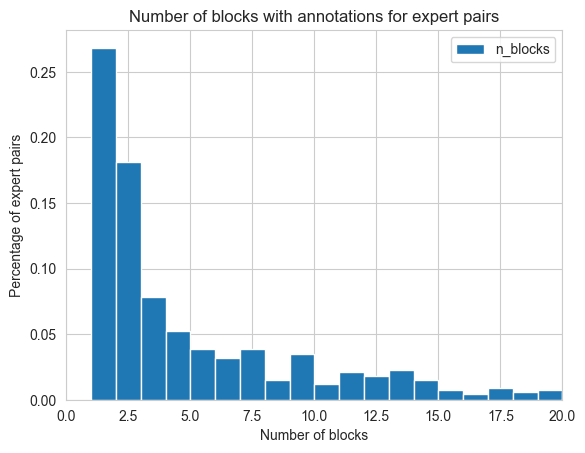

In [10]:
metrics_exp_pairs_df.plot.hist(y='n_blocks', bins=sorted(metrics_exp_pairs_df['n_blocks'].unique()), density=True)
plt.xlim(0, 20)
plt.xlabel('Number of blocks')
plt.ylabel('Percentage of expert pairs')
plt.title('Number of blocks with annotations for expert pairs')
plt.show()

In [11]:
grp = expert_epoch_views_df.groupby(['subID', 'blockNum'])
print(f"Number of unique blocks: {len(grp.groups.keys())}")
print(
    f"Number of annotators per block: min={min(grp['annotatorID'].nunique())}, max={max(grp['annotatorID'].nunique())}")
print(f"Number of annotators in total: {expert_epoch_views_df['annotatorID'].nunique()}")
print(f"Number of expert pairs with more than 5 blocks: {len(metrics_exp_pairs_df.query('n_blocks >= 5'))}")

Number of unique blocks: 749
Number of annotators per block: min=1, max=7
Number of annotators in total: 47
Number of expert pairs with more than 5 blocks: 280


In [12]:
# remove pairs with less than 5 blocks
metrics_exp_pairs_df = metrics_exp_pairs_df.query('n_blocks >= 5')

In [13]:
f1s = np.concatenate(metrics_exp_pairs_df['f1'].values)[:, None].reshape(-1, len(overlap_thresholds))

# Figure for paper

Percentage of expert pairs with F1 score < 0.5: 25.00%
Mean F1 score: 0.59, Std F1 score: 0.16
Quartiles F1 score: [0.49925447 0.61980068 0.71072992]
Std MODA experts: 0.08
Quartiles MODA experts: [0.64835165 0.73913043 0.78125   ]


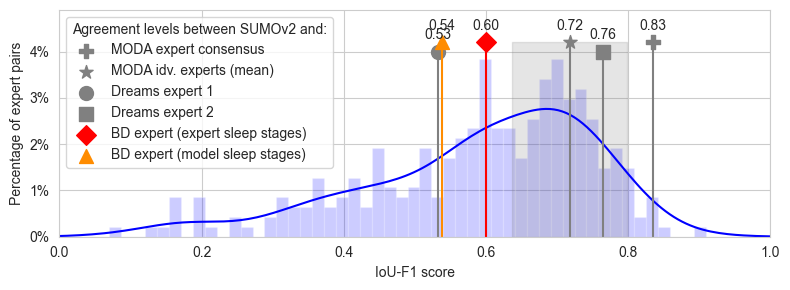

In [14]:
plt.figure(figsize=(8, 3))
plt.hist(f1s[:, 4], bins=50, density=True, alpha=0.2, color='blue')
sns.kdeplot(f1s[:, 4], color='blue')

markers = ['o', 's', 'D', '^', 'P', '*', '>', 'p', 'P', '*', 'X', 'd', 'H', 'h', '+', 'x', '|', '_', '.', ',']
max_y = max(plt.yticks()[0]) - 1

print(f"Percentage of expert pairs with F1 score < 0.5: {np.sum(f1s[:, 4] < 0.5) / len(f1s) * 100:.2f}%")
print(f"Mean F1 score: {f1s[:, 4].mean():.2f}, Std F1 score: {f1s[:, 4].std():.2f}")
print(f"Quartiles F1 score: {np.quantile(f1s[:, 4], [0.25, 0.5, 0.75])}")

# green
plt.vlines(moda_scores['sumov2']['f1'], 0, max_y + 0.2, color='grey')
plt.text(moda_scores['sumov2']['f1'], max_y + 0.4, f"{moda_scores['sumov2']['f1']:.2f}", verticalalignment='bottom',
         horizontalalignment='center')
plt.scatter(moda_scores['sumov2']['f1'], max_y + 0.2, color='grey', marker=markers[4], s=100,
            label='MODA expert consensus')

moda_f1s_sumo_vs_expert = np.array([0.53372009, 0.73913043, 0.64935065, 0.83544304, 0.69387755,
                                    0.60536398, 0.62745098, 0.6519337, 0.76086957, 0.75449102,
                                    0.75229358, 0.79646018, 0.8, 0.76277372, 0.85393258,
                                    0.61269841, 0.75789474, 0.78125, 0.8137931, 0.81538462,
                                    0.76681614, 0.63247863, 0.64, 0.68199234, 0.73015873,
                                    0.70588235, 0.64835165, 0.61716937, 0.79411765])
# lime
plt.vlines(moda_f1s_sumo_vs_expert.mean(), 0, max_y + 0.2, color='grey')
plt.fill_betweenx([0, max_y + 0.2], moda_f1s_sumo_vs_expert.mean() - moda_f1s_sumo_vs_expert.std(),
                  moda_f1s_sumo_vs_expert.mean() + moda_f1s_sumo_vs_expert.std(), color='grey', alpha=0.2)
plt.text(moda_f1s_sumo_vs_expert.mean(), max_y + 0.4, f"{moda_f1s_sumo_vs_expert.mean():.2f}",
         verticalalignment='bottom', horizontalalignment='center')
# put a symbol on top of the mean line
plt.scatter(moda_f1s_sumo_vs_expert.mean(), max_y + 0.2, color='grey', marker=markers[5], s=100,
            label='MODA idv. experts (mean)')
print(f"Std MODA experts: {moda_f1s_sumo_vs_expert.std():.2f}")
print(f"Quartiles MODA experts: {np.quantile(moda_f1s_sumo_vs_expert, [0.25, 0.5, 0.75])}")

# purple
plt.vlines(dreams_scores['sumov2 exp1']['f1'], 0, max_y, color='grey')
plt.text(dreams_scores['sumov2 exp1']['f1'], max_y + 0.2, f"{dreams_scores['sumov2 exp1']['f1']:.2f}",
         verticalalignment='bottom', horizontalalignment='center')
plt.scatter(dreams_scores['sumov2 exp1']['f1'], max_y, color='grey', marker=markers[0], s=100,
            label='Dreams expert 1')
# violet
plt.vlines(dreams_scores['sumov2 exp2']['f1'], 0, max_y, color='grey')
plt.text(dreams_scores['sumov2 exp2']['f1'], max_y + 0.2, f"{dreams_scores['sumov2 exp2']['f1']:.2f}",
         verticalalignment='bottom', horizontalalignment='center')
plt.scatter(dreams_scores['sumov2 exp2']['f1'], max_y, color='grey', marker=markers[1], s=100,
            label='Dreams expert 2')

plt.vlines(nikitin_scores['sumov2']['f1'], 0, max_y + 0.2, color='red')
plt.text(nikitin_scores['sumov2']['f1'], max_y + 0.4, f"{nikitin_scores['sumov2']['f1']:.2f}",
         verticalalignment='bottom', horizontalalignment='center')
plt.scatter(nikitin_scores['sumov2']['f1'], max_y + 0.2, color='red', marker=markers[2], s=100,
            label='BD expert (expert sleep stages)')
plt.vlines(nikitin_scores['sumov2 RSN']['f1'], 0, max_y + 0.2, color='darkorange')
plt.text(nikitin_scores['sumov2 RSN']['f1'], max_y + 0.4, f"{nikitin_scores['sumov2 RSN']['f1']:.2f}",
         verticalalignment='bottom', horizontalalignment='center')
plt.scatter(nikitin_scores['sumov2 RSN']['f1'], max_y + 0.2, color='darkorange', marker=markers[3], s=100,
            # label='Nikitin with RSN sleep stages')
            label='BD expert (model sleep stages)')

y_ticks = plt.yticks()[0][:-1]
plt.yticks(y_ticks, [f'{t:.0f}%' for t in y_ticks])
plt.xlim(0, 1)
plt.ylim(0, max_y + 0.9)
plt.xlabel('IoU-F1 score')
plt.ylabel('Percentage of expert pairs')
plt.legend(title='Agreement levels between SUMOv2 and:', alignment="left")
plt.tight_layout()
plt.savefig('figures/sumo-vs-expert-pairs.svg')
plt.show()